In [54]:
import autograd
import autograd.numpy as ag_np
import numpy as np
import matplotlib.pyplot as plt
from autograd.scipy.special import expit as ag_expit
import scipy.optimize
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors
import torch
import pandas as pd
import os
from matplotlib.ticker import FormatStrFormatter
from autograd.scipy.special import expit as ag_logistic_sigmoid
import seaborn as sns
from AdversarialPredictionUtils import LinearClassifier, RecallGvPrecision, TabularDataset
from ap_perf import PerformanceMetric, MetricLayer
from torch.utils.data import Dataset, DataLoader, random_split
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Create Toy Data

In [2]:
# generate 225 positive data points
n_P = [30, 60, 30]
# n_P = [60, 120, 60]
P = 3
prng = np.random.RandomState(101)

# the first 25 data points come from mean 2-D mvn with mean [1, 2.5] and next 200 come from
# 2-D mvn with mean [1, 1]
mu_PD = np.asarray([
    [0.7, 2.5],
    [0.7, 1.0],
    [0.7, 0.0]])
    
cov_PDD = np.vstack([
    np.diag([0.06, 0.1])[np.newaxis,:],
    np.diag([0.1, 0.1])[np.newaxis,:],
    np.diag([0.06, 0.06])[np.newaxis,:],
    ])

xpos_list = list()
for p in range(P):
    x_ND = prng.multivariate_normal(mu_PD[p], cov_PDD[p], size=n_P[p])
    xpos_list.append(x_ND)
x_pos_ND = np.vstack(xpos_list)
y_pos_N  = np.ones(x_pos_ND.shape[0])

# generate 340 negative data points
n_P = [400, 30, 20]
# n_P = [800, 60, 40]
P = 3
prng = np.random.RandomState(201)

# the first 300 data points come from mean 2-D mvn with mean [2.2, 1.5] and next 20 come from
# 2-D mvn with mean [0, 3] and next 20 from 2-D mvn with mean [0, 0.5]
mu_PD = np.asarray([
    [2.25, 1.5],
    [0.0, 3.0],
    [0.0, 0.5],
    ])
    
cov_PDD = np.vstack([
    np.diag([.1, .2])[np.newaxis,:],
    np.diag([.05, .05])[np.newaxis,:],
    np.diag([.05, .05])[np.newaxis,:],
    ])

xneg_list = list()
for p in range(P):
    x_ND = prng.multivariate_normal(mu_PD[p], cov_PDD[p], size=n_P[p])
    xneg_list.append(x_ND)
x_neg_ND = np.vstack(xneg_list)
y_neg_N = np.zeros(x_neg_ND.shape[0])

x_ND = np.vstack([x_pos_ND, x_neg_ND])
y_N = np.hstack([y_pos_N, y_neg_N])

x_ND = (x_ND - np.mean(x_ND, axis=0))/np.std(x_ND, axis=0)

x_pos_ND = x_ND[y_N == 1]
x_neg_ND = x_ND[y_N == 0]

prng = np.random.RandomState(0)
shuffle_ids = prng.permutation(y_N.size)

print('frac positive = %.2f'%((y_N==1).sum()/len(y_N)))

frac positive = 0.21


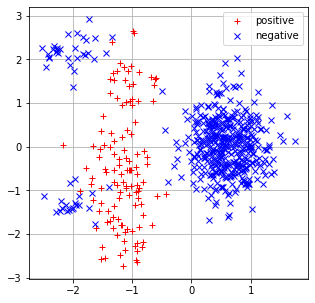

(-3.0, 3.0)

In [3]:
f, axs = plt.subplots(1, 1, figsize=(5,5))
axs.plot(x_pos_ND[:,0], x_pos_ND[:,1], 'r+', label='positive')
axs.plot(x_neg_ND[:,0], x_neg_ND[:,1], 'bx', label='negative')
axs.grid(True)
axs.legend()
plt.show()
axs.set_xlim([-3, 3])

## Define function to plot the decision boundary

In [4]:
def calc_decision_score(x, w):
    return ag_np.dot(x, w[:2]) + w[2]

def calc_cross_entropy_loss(w_D):  
    ry_N = ag_np.sign(y_N-0.01)*(ag_np.dot(x_ND, w_D[:2]) + w_D[2])
    cross_ent = ag_np.sum(ag_np.log(ag_expit(ry_N)+1e-15))# add 1e-15 to avoid precision problems
    return -1.0*cross_ent

grad_cross_entropy_loss = autograd.grad(calc_cross_entropy_loss)


def pretty_plot_of_decision_boundary(
        w_D, level_grid = [-1.0, 0.0, 1.0],
        G=51, H=51, figsize=(3,3),
        x1_lims=(-2, 6), x2_lims=(-2, 6), title_str='', thresh=0.0): 


    redblue_colors = plt.cm.RdBu(np.linspace(0, 1, 101))
    redblue_cmap = matplotlib.colors.ListedColormap(redblue_colors)
    redblue_cmap_r = matplotlib.colors.ListedColormap(redblue_cmap.colors[::-1])
    
    fig, ax_h = plt.subplots(figsize=figsize)
    sns.set_context("notebook", font_scale=1.5)
    divider = make_axes_locatable(ax_h)
    cax = divider.append_axes('right', size='5%', pad=0.2)
    ax_h.set_xlim(x1_lims)
    ax_h.set_ylim(x2_lims)

    ax_h.plot(x_neg_ND[:,0], x_neg_ND[:,1], 'x', color=redblue_colors[-1])
    ax_h.plot(x_pos_ND[:,0], x_pos_ND[:,1], '+', color=redblue_colors[0])
    ax_h.set_xlabel(r'$x_1$')
    ax_h.set_ylabel(r'$x_2$')
    w_str = ' '.join(['% .2f' % a for a in w_D])
    
    x0_G = np.linspace(*ax_h.get_xlim(), num=G)
    x1_H = np.linspace(*ax_h.get_ylim(), num=H)
    G = x0_G.size
    H = x1_H.size

    # J = G * H
    X0_HG, X1_HG = np.meshgrid(x0_G, x1_H)
    assert X0_HG.shape == (H, G)
    x_JD = np.hstack([X0_HG.flatten()[:,np.newaxis], X1_HG.flatten()[:,np.newaxis]])
    assert np.allclose(X0_HG, x_JD[:,0].reshape((H,G)))
    
    z_J = calc_decision_score(x_JD, w_D)
    Z_HG = z_J.reshape((H,G))

    B_HG = 2.0 * (Z_HG > 0) - 1.0
    
    L = np.maximum(len(level_grid), 11)
    level_colors = plt.cm.Greys(np.linspace(0, 1, L))

    # Get grays in the middle range
    m = L // 2
    nrem = len(level_grid)
    mlow = m - nrem // 2
    mhigh = m + nrem // 2 + 1
    if mhigh - mlow < len(level_grid):
        mhigh += 1
    print(mlow, mhigh, L)
    level_cmap = matplotlib.colors.ListedColormap(level_colors[mlow:mhigh])
        
    ax_h.contour(
        X0_HG, X1_HG, Z_HG,
        levels=level_grid,
        cmap=level_cmap,
        vmin=-5, vmax=+5);
    im = ax_h.pcolormesh(
        X0_HG, X1_HG, ag_expit(Z_HG),
        alpha=1.0, linewidth=0,
        cmap=redblue_cmap_r,
        edgecolor='face', vmin=0.0, vmax=1.0);
    #im.set_edgecolor((1.0, 1.0, 1.0, 0.001))
    im.set_linewidth(0.0)
    im.set_alpha(0.25)

    cbar = plt.colorbar(im, cax=cax, ticks=[0, 0.2, 0.4, 0.6, 0.8])
    cbar.set_alpha(0.25)
    cbar.draw_all()

    z_N = calc_decision_score(x_ND, w_D)
    yhat_N = np.float64(z_N >= thresh)
    TP = np.sum(np.logical_and(y_N == 1, yhat_N == 1))
    FP = np.sum(np.logical_and(y_N == 0, yhat_N == 1))
    TN = np.sum(np.logical_and(y_N == 0, yhat_N == 0))
    FN = np.sum(np.logical_and(y_N == 1, yhat_N == 0))
    precision = TP / (1e-10 + float(TP+FP))
    recall = TP / (1e-10 + float(TP + FN))

    ax_h.set_title("%s\n Prec:%.3f  Rec:%.3f  CE:% .1f\n" % (
        title_str, precision, recall, calc_cross_entropy_loss(w_D)))
#     ax_h.set_xticks(np.linspace(x1_lims[0], x1_lims[1])[::4])
#     ax_h.set_yticks(np.linspace(x2_lims[0], x2_lims[1])[::4])
    ""
    
    #print("w_D: %s" % (str(w_D)))
    for level_thr in level_grid:
        # Assess each training point at this level
        z_N = calc_decision_score(x_ND, w_D)
        yhat_N = np.float64(z_N >= level_thr)
        TP = np.sum(np.logical_and(y_N == 1, yhat_N == 1))
        FP = np.sum(np.logical_and(y_N == 0, yhat_N == 1))
        TN = np.sum(np.logical_and(y_N == 0, yhat_N == 0))
        FN = np.sum(np.logical_and(y_N == 1, yhat_N == 0))
        precision = TP / (1e-10 + float(TP+FP))
        recall = TP / (1e-10 + float(TP + FN))
        print("thr % 6.3f | cross_entropy %.3f | precision %.3f | recall %.3f | TP %5d | FP %5d | TN %5d | FN %5d" % (
            level_thr, 
            calc_cross_entropy_loss(w_D),
            precision, recall, TP, FP, TN, FN))
        
    
    return precision, recall


## Define loss functions

In [27]:
## Define functions for loose hinge bounds
def calculate_hinge_loss(w_D, thresh=0.0):
    return ag_np.maximum(0.0, 1.0-(ag_np.sign(y_N-.01)*(ag_np.dot(x_ND, w_D[:2]) + w_D[2] - thresh)))

def calculate_fp_upper_bound_loose(w_D, thresh=0.0):
    '''
    Calculate false positive upper bound with hinge loss only on negative examples 
    '''
    return ag_np.sum(calculate_hinge_loss(w_D, thresh=thresh)[y_N==0])

def calculate_tp_lower_bound_loose(w_D, thresh=0.0):
    '''
    Calculate true positive lower bound with hinge loss only on positive examples
    '''
    return ag_np.sum(1-(calculate_hinge_loss(w_D, thresh=thresh)[y_N==1]))


## functions for creating sigmoid bounds given gamma, delta, epsilon
def calc_s(r, m, b, gamma=2.0, delta=.01):
    return (1.0 + gamma*delta) * ag_logistic_sigmoid(m * r + b)

def make_loss_and_grad_FPUB(gamma, delta, epsilon):
    def calc_loss(mb_vec):
        m = mb_vec[0]
        b = mb_vec[1]
        return (
            ag_np.square(delta - calc_s(-epsilon, m, b, gamma, delta))
            + ag_np.square(1.0 + delta - calc_s(0.0, m, b, gamma, delta))
        )
    calc_grad = autograd.grad(calc_loss)
    return calc_loss, calc_grad

def make_calc_sigmoid_FPUB(gamma, delta, epsilon):
    calc_loss, calc_grad = make_loss_and_grad_FPUB(gamma, delta, epsilon)
    ans = scipy.optimize.minimize(
        fun=calc_loss,
        x0=ag_np.asarray([0.0, 0.0]),
        jac=calc_grad,
        options=dict(ftol=1e-13, gtol=0.0),
        method='L-BFGS-B')
    m = ans.x[0]
    b = ans.x[1]
    def calc_sigmoid(r):
        return (1 + gamma * delta) * ag_logistic_sigmoid(r * m + b)

    return calc_sigmoid, m, b

def make_loss_and_grad_TPLB(gamma, delta, epsilon):
    def calc_loss(mb_vec):
        m = mb_vec[0]
        b = mb_vec[1]
        return (
            ag_np.square(delta - calc_s(0.0, m, b, gamma, delta))
            + ag_np.square(1.0 + delta - calc_s(epsilon, m, b, gamma, delta))
        )
    calc_grad = autograd.grad(calc_loss)
    return calc_loss, calc_grad

def make_calc_sigmoid_TPLB(gamma, delta, epsilon):
    calc_loss, calc_grad = make_loss_and_grad_TPLB(gamma, delta, epsilon)
    ans = scipy.optimize.minimize(
        fun=calc_loss,
        x0=ag_np.asarray([0.0, 0.0]),
        jac=calc_grad,
        options=dict(ftol=1e-13, gtol=0.0),
        method='L-BFGS-B')
    def calc_sigmoid(r):
        return (1 + gamma * delta) * ag_logistic_sigmoid(r * ans.x[0] + ans.x[1])
    m = ans.x[0]
    b = ans.x[1]
    return calc_sigmoid, m, b

# calc_sigmoid_FPUB, m_FPUB, b_FPUB = make_calc_sigmoid_FPUB(7.00, 0.021, 0.735)
# calc_sigmoid_TPLB, m_TPLB, b_TPLB = make_calc_sigmoid_TPLB(7.00, 0.035, 0.99)
calc_sigmoid_FPUB, m_FPUB, b_FPUB = make_calc_sigmoid_FPUB(7.00, 0.035, 0.75)
calc_sigmoid_TPLB, m_TPLB, b_TPLB = make_calc_sigmoid_TPLB(7.00, 0.035, 0.75)


## functions for computing tight bounds
def calculate_tp_lower_bound_better(w_D, thresh=0.0):
    scores_N = (ag_np.dot(x_ND, w_D[:2]) + w_D[2] - thresh)
    return ag_np.sum(calc_sigmoid_TPLB(scores_N[y_N==1]))

def calculate_fp_upper_bound_better(w_D, thresh=0.0):
    scores_N = (ag_np.dot(x_ND, w_D[:2]) + w_D[2] - thresh)
    return ag_np.sum(calc_sigmoid_FPUB(scores_N[y_N==0]))

def calculate_surrogate_loss(w_D, thresh=0.0, lamb=1.0, alpha=0.9, loose_bounds=True):
    frac_alpha=alpha/(1-alpha)
    if loose_bounds==True:
        g_theta = -calculate_tp_lower_bound_loose(w_D, thresh=thresh) + \
                                                    frac_alpha*calculate_fp_upper_bound_loose(w_D, thresh=thresh)

        if g_theta>=0:
            penalty = g_theta
        else:
            penalty = 0
        
        surr_loss_loose = -calculate_tp_lower_bound_loose(w_D, thresh=thresh) + lamb*penalty
        return surr_loss_loose
    else:
        g_theta = -calculate_tp_lower_bound_better(w_D, thresh=thresh) + \
                                                    frac_alpha*calculate_fp_upper_bound_better(w_D, thresh=thresh)    
        if g_theta>=0:
            penalty = g_theta
        else:
            penalty = 0
        surr_loss_tight = -calculate_tp_lower_bound_better(w_D, thresh=thresh) + lamb*penalty
        return surr_loss_tight

    
grad_surrogate_loss = autograd.grad(calculate_surrogate_loss)

## Maximize recall subject to precision>=0.8 and precision>=0.9 for the following methods
- ### BCE, BCE+Threshold search
- ### Hinge bound, Hinge bound+Threshold search
- ### Our proposed sigmoid bound
- ### Adversarial Prediction (Kolter)

## Maximize recall at precision>=0.8 with BCE + Threshold search

5 6 11
thr  0.000 | cross_entropy 177.120 | precision 0.681 | recall 0.642 | TP    77 | FP    36 | TN   414 | FN    43
5 6 11
thr  0.000 | cross_entropy 223.481 | precision 0.684 | recall 0.900 | TP   108 | FP    50 | TN   400 | FN    12


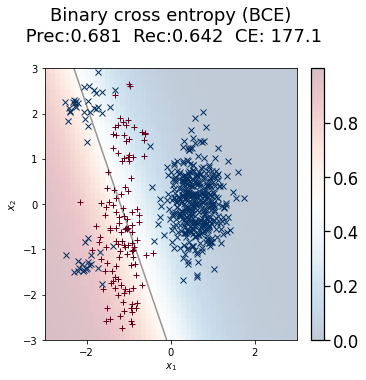

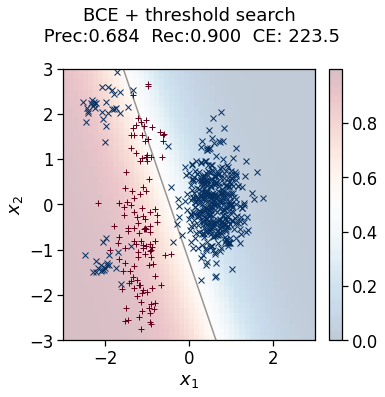

In [6]:
## max recall at precision>=0.8
init_w_D = ag_np.asarray([-1.0,1.0, 0.0])
ans = scipy.optimize.minimize(
    fun=calc_cross_entropy_loss,
    x0=init_w_D,
    jac=grad_cross_entropy_loss,
    method='L-BFGS-B')

opt_w_D_bce_scipy = ans.x

pretty_plot_of_decision_boundary(opt_w_D_bce_scipy, level_grid = [0.0],
                                 figsize=(5,5), x1_lims=(-3, 3), x2_lims=(-3, 3), title_str='Binary cross entropy (BCE)')

plt.savefig('BCE_solution.png', bbox_inches='tight', pad_inches=0)

opt_w_D_bce_scipy_plus_thresh = opt_w_D_bce_scipy + np.array([0, 0, 1.25])

pretty_plot_of_decision_boundary(opt_w_D_bce_scipy_plus_thresh, level_grid = [0.0],
                                 figsize=(5,5), x1_lims=(-3, 3), x2_lims=(-3, 3), title_str='BCE + threshold search')

plt.savefig('BCE_plus_threshold_solution.png', bbox_inches='tight', pad_inches=0)

## Maximize recall at precision>=0.8, and precision>=0.9 with Hinge Bound and Hinge Bound + Threshold Search

5 6 11
thr  0.000 | cross_entropy 214.765 | precision 0.726 | recall 0.442 | TP    53 | FP    20 | TN   430 | FN    67
5 6 11
thr  0.000 | cross_entropy 231.735 | precision 0.798 | recall 0.658 | TP    79 | FP    20 | TN   430 | FN    41
5 6 11
thr  0.000 | cross_entropy 238.632 | precision 1.000 | recall 0.017 | TP     2 | FP     0 | TN   450 | FN   118


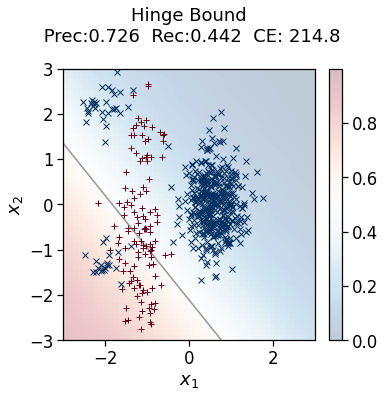

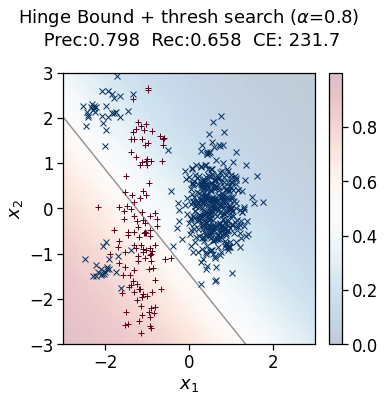

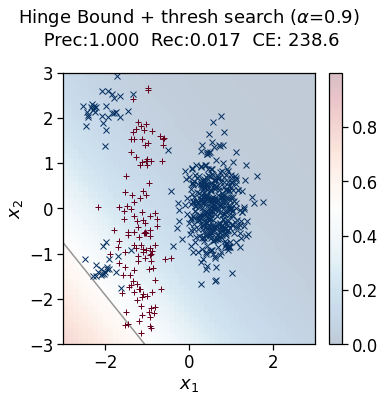

In [28]:
## max recall at precision>=0.8
ans = scipy.optimize.minimize(
    fun=calculate_surrogate_loss,
    x0=np.random.randn(3),
    jac=grad_surrogate_loss,
    args=(0.0, 1.0, 0.8, True),
    method='L-BFGS-B')

opt_w_D_sl_loose_80_scipy = ans.x

pretty_plot_of_decision_boundary(opt_w_D_sl_loose_80_scipy, level_grid = [0.0],
                                 figsize=(5,5), x1_lims=(-3, 3), x2_lims=(-3, 3), title_str='Hinge Bound')

plt.savefig('precision_80_solution_hinge_bound.png', bbox_inches='tight', pad_inches=0)

pretty_plot_of_decision_boundary(opt_w_D_sl_loose_80_scipy + np.array([0., 0., 0.38]), level_grid = [0.0],
                                 figsize=(5,5), x1_lims=(-3, 3), x2_lims=(-3, 3), title_str=r'Hinge Bound + thresh search ($\alpha$=0.8)')

plt.savefig('precision_80_solution_hinge_bound_plus_threshold_search.png', bbox_inches='tight', pad_inches=0)


pretty_plot_of_decision_boundary(opt_w_D_sl_loose_80_scipy + np.array([0., 0., -1.2]), level_grid = [0.0],
                                 figsize=(5,5), x1_lims=(-3, 3), x2_lims=(-3, 3), title_str=r'Hinge Bound + thresh search ($\alpha$=0.9)')

plt.savefig('precision_90_solution_hinge_bound_plus_threshold_search.png', bbox_inches='tight', pad_inches=0)

## Maximize recall at precision>=0.8, and precision>=0.9 with Our Proposed Sigmoid Bounds

5 6 11
thr  0.000 | cross_entropy 216.026 | precision 0.802 | recall 0.742 | TP    89 | FP    22 | TN   428 | FN    31
5 6 11
thr  0.000 | cross_entropy 2072.640 | precision 0.962 | recall 0.208 | TP    25 | FP     1 | TN   449 | FN    95


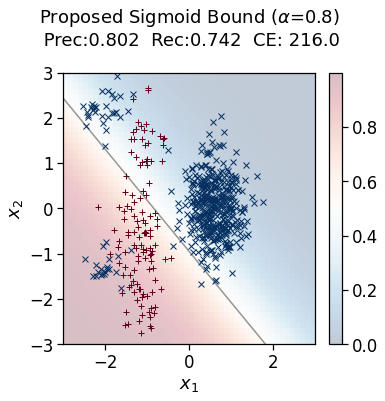

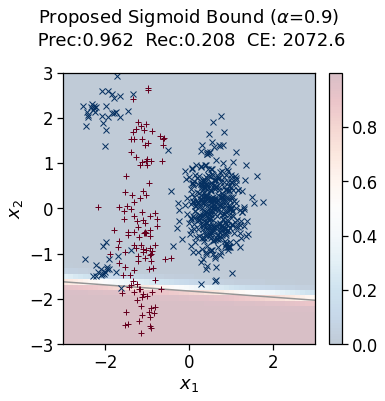

In [43]:
np.random.seed(190921)#210
ans = scipy.optimize.minimize(
    fun=calculate_surrogate_loss,
    x0=np.random.randn(3),
    jac=grad_surrogate_loss,
    args=(0.0, 1000.0, 0.8, False),
    method='L-BFGS-B')

opt_w_D_sl_tight_80_scipy = ans.x/abs(max(ans.x))

pretty_plot_of_decision_boundary(opt_w_D_sl_tight_80_scipy, level_grid = [0.0],
                                 figsize=(5,5), x1_lims=(-3, 3), x2_lims=(-3, 3), title_str=r'Proposed Sigmoid Bound ($\alpha$=0.8)')

plt.savefig('precision_80_solution_tight_sigmoid_bound.png', bbox_inches='tight', pad_inches=0)

np.random.seed(1)
ans = scipy.optimize.minimize(
    fun=calculate_surrogate_loss,
    x0=np.random.randn(3),
    jac=grad_surrogate_loss,
    args=(0.0, 1000.0, 0.9, False),
    method='L-BFGS-B')

opt_w_D_sl_tight_90_scipy = ans.x/abs(max(ans.x))

pretty_plot_of_decision_boundary(opt_w_D_sl_tight_90_scipy, level_grid = [0.0],
                                 figsize=(5,5), x1_lims=(-3, 3), x2_lims=(-3, 3), title_str=r'Proposed Sigmoid Bound ($\alpha$=0.9)')

plt.savefig('precision_90_solution_tight_sigmoid_bound.png', bbox_inches='tight', pad_inches=0)

## Maximize recall at precision>=0.8, and precision>=0.9 with Adversarial Prediction (Kolter)


#0 | Acc tr: 0.88947 | Metric tr: 0.89167 | Constraint tr: 0.68153

#1 | Acc tr: 0.89825 | Metric tr: 0.69167 | Constraint tr: 0.79808
5 6 11
thr  0.000 | cross_entropy 279.222 | precision 0.798 | recall 0.692 | TP    83 | FP    21 | TN   429 | FN    37


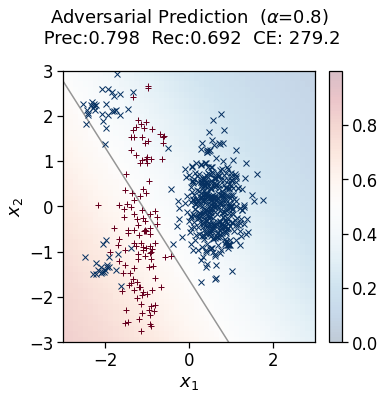

In [62]:
## train with adversarial prediction (takes time)
recall_gv_precision_80 = RecallGvPrecision(0.8)
recall_gv_precision_80.initialize()
recall_gv_precision_80.enforce_special_case_positive()
recall_gv_precision_80.set_cs_special_case_positive(True)


# performance metric
pm = recall_gv_precision_80

trainset = TabularDataset(x_ND, y_N)


batch_size = len(x_ND) # full batch
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

method = "ap-perf"              # uncomment if we want to use ap-perf objective 
# method = "bce-loss"           # uncomment if we want to use bce-loss objective

torch.manual_seed(189)
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

nvar = x_ND.shape[1]
model = LinearClassifier(nvar).to(device)

if method == "ap-perf":
    criterion = MetricLayer(pm).to(device)
    lr = 3e-3
    weight_decay = 0
else:
    criterion = nn.BCEWithLogitsLoss().to(device)
    lr = 1e-2
    weight_decay = 1e-3

optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)

for epoch in range(2): # epoch 2 was the best checkpoint after running 50 epochs

    for i, (inputs, labels) in enumerate(trainloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        output = model(inputs)

        loss = criterion(output, labels)

        loss.backward()
        optimizer.step()

    print()

    # evaluate after each epoch
    model.eval()

    # train
    train_data = torch.tensor(x_ND).to(device)
    tr_output = model(train_data)
    tr_pred = (tr_output >= 0.0).float()
    tr_pred_np = tr_pred.cpu().numpy()

    train_acc = np.sum(y_N == tr_pred_np) / len(y_N)
    train_metric = pm.compute_metric(tr_pred_np, y_N)
    train_constraint = pm.compute_constraints(tr_pred_np, y_N)


    model.train()

    print('#{} | Acc tr: {:.5f} | Metric tr: {:.5f} | Constraint tr: {:.5f}'.format(
        epoch, train_acc, train_metric, train_constraint[0]))

opt_w_D_adversarial_80 = np.zeros(3)
opt_w_D_adversarial_80[:2] = list(model.parameters())[0].data[0]
opt_w_D_adversarial_80[2] = list(model.parameters())[1].data[0]

# manually set the weight from training earlier, because training takes time
# opt_w_D_adversarial_80 = ag_np.asarray([-.41, -0.27, -0.46])
pretty_plot_of_decision_boundary(opt_w_D_adversarial_80, level_grid = [0.0],
                                 figsize=(5,5), x1_lims=(-3, 3), x2_lims=(-3, 3), title_str=r'Adversarial Prediction  ($\alpha$=0.8)')

plt.savefig('precision_80_solution_adversarial_prediction.png', bbox_inches='tight', pad_inches=0)
